In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import models  # <-- ResNet models come from here

In [2]:
# --------- Classifier Head (Same as before) ---------
class COVIDNetClassifierLarge(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(COVIDNetClassifierLarge, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [3]:
# --------- Preprocessing ---------
def get_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),       # ResNet prefers 224x224
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])

In [4]:
# --------- Prediction Function ---------
def predict_image(image_path, model, backbone, class_names, labels_csv=None):
    # Load and preprocess image
    original_image = Image.open(image_path).convert('RGB')
    display_image = np.array(original_image)

    transform = get_transform()
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    # Feature extraction
    with torch.no_grad():
        backbone.eval()
        features = backbone(input_tensor)
        features_flat = features.view(1, -1)

    # Classification
    model.eval()
    with torch.no_grad():
        outputs = model(features_flat.to(device))
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    # Fetch true label
    true_label = None
    if labels_csv:
        df = pd.read_csv(labels_csv, header=None, names=['image', 'label'])
        img_name = os.path.basename(image_path)
        row = df[df['image'] == img_name]
        if not row.empty:
            true_label_idx = int(row.iloc[0]['label'])
            true_label = class_names[true_label_idx]

    # Display image
    plt.imshow(display_image)
    plt.title(f"{os.path.basename(image_path)}\nPredicted: {class_names[pred]} ({probs[0][pred]*100:.2f}%)")
    plt.axis('off')
    plt.show()

    # Print results
    print(f"\n📸 Image: {os.path.basename(image_path)}")
    print(f"✅ Predicted: {class_names[pred]} (with probability: {probs[0][pred]*100:.2f}%)")
    if true_label:
        print(f"🎯 Actual:    {true_label}")

C:\MyPrograms\Anaconda\envs\tf_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\MyPrograms\Anaconda\envs\tf_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Safi\AppData\Local\Temp\ipykernel_30432\3548898316.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pyto

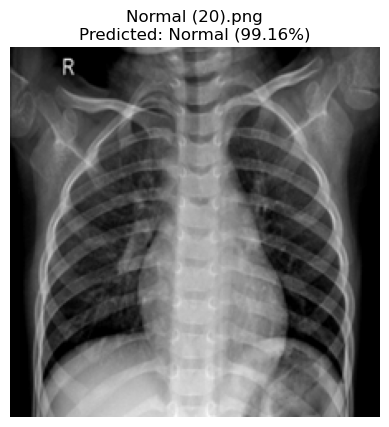


📸 Image: Normal (20).png
✅ Predicted: Normal (with probability: 99.16%)
🎯 Actual:    Normal


In [7]:
# --------- Main ---------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Paths
    image_path = "resnet_dataset/test/Normal (20).png"
    labels_csv = "resnet_dataset/test/test_mapping.csv"
    model_path = "best_resnet_covidnet.pt"

    # Setup
    num_classes = 3
    class_names = ['COVID-19', 'Non-COVID', 'Normal']  # Same mapping
    
    # Load ResNet backbone
    backbone = models.resnet50(pretrained=True)
    # Remove final classification layer (fc)
    backbone = nn.Sequential(*list(backbone.children())[:-1])  # Remove fc
    backbone = nn.Sequential(
        backbone,
        nn.Flatten()  # (batch, 2048)
    )
    backbone = backbone.to(device)

    # Load classifier
    input_dim = 2048  # ResNet50 output features
    model = COVIDNetClassifierLarge(input_dim=input_dim, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

    # Predict
    predict_image(image_path, model, backbone, class_names, labels_csv)